In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import os
import glob
import torch
from tqdm import tqdm
from helpers import *
from sklearn.preprocessing import MinMaxScaler
from model import *

In [2]:
data = pd.read_csv('data_from_news.csv')
data

,Date,State,Occurence
0,2019-01-04,illinois,1
1,2019-01-08,illinois,1
2,2019-01-05,illinois,1
3,2019-01-08,illinois,1
4,2019-01-08,alaska,1
...,...,...,...
9621,2021-04-08,illinois,1
9622,2021-04-07,illinois,1
9623,2021-04-08,illinois,1
9624,2021-04-09,illinois,1


In [3]:
# Group data by weeks
# matrix, date = convert_data_to_matrix(data, group_data = True, group_days = 7)
matrix, date = convert_data_to_matrix(data)
matrix.shape

(831, 50)

In [4]:
# scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize data by row
# Transpose input data as MinMaxScaler normalize by columns in default
# matrix = scaler.fit_transform(matrix.T).T

In [5]:
x, y = get_x_y(matrix, lookback = 4)
print(x.shape)
print(y.shape)
date = date[:x.shape[0]]
print(date.shape)

(827, 4, 50)
(827, 50)
(827,)


In [6]:
train_loader, test_loader = split_data(x, y)

In [7]:
input_dim = matrix.shape[-1]
hidden_dim = 32
num_layers = 2
output_dim = matrix.shape[-1]
num_epochs = 200

In [8]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
start = time.time()
LOSS, ACCU = [], []

# num_epochs = 10
for epoch in range(num_epochs):
    rloss = []
    acc = []
    for data in train_loader:
        x, y = data
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        rloss.append(loss.item())

    with torch.no_grad():
        for data in test_loader:
            x, y = data
            output = model(x)
            pred = get_pred(output)
            accu = calc_accuracy(pred, y)
            acc.append(accu)

    LOSS.append(np.mean(rloss))
    ACCU.append(np.mean(acc))

    print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.2f}%".format(epoch, num_epochs, LOSS[-1], ACCU[-1] * 100))
train_time = time.time() - start
print("Total train time: {} hrs {} mins".format(int(train_time // 3600), int(train_time % 3600 // 60)))


Epoch 0/200, Loss: 2825.916, Accuracy: 60.00%
Epoch 1/200, Loss: 1652.468, Accuracy: 90.87%
Epoch 2/200, Loss: 1588.115, Accuracy: 91.01%
Epoch 3/200, Loss: 1572.281, Accuracy: 84.10%
Epoch 4/200, Loss: 1550.519, Accuracy: 91.71%
Epoch 5/200, Loss: 1534.316, Accuracy: 91.68%
Epoch 6/200, Loss: 1564.251, Accuracy: 86.68%
Epoch 7/200, Loss: 1576.100, Accuracy: 89.68%
Epoch 8/200, Loss: 1547.734, Accuracy: 89.53%
Epoch 9/200, Loss: 1462.248, Accuracy: 86.81%
Epoch 10/200, Loss: 1541.913, Accuracy: 85.81%
Epoch 11/200, Loss: 1573.537, Accuracy: 86.73%
Epoch 12/200, Loss: 1564.723, Accuracy: 91.78%
Epoch 13/200, Loss: 1513.787, Accuracy: 88.53%
Epoch 14/200, Loss: 1562.557, Accuracy: 91.17%
Epoch 15/200, Loss: 1438.792, Accuracy: 89.33%
Epoch 16/200, Loss: 1559.203, Accuracy: 85.59%
Epoch 17/200, Loss: 1566.958, Accuracy: 89.89%
Epoch 18/200, Loss: 1545.721, Accuracy: 92.28%
Epoch 19/200, Loss: 1541.832, Accuracy: 91.48%
Epoch 20/200, Loss: 1490.572, Accuracy: 92.39%
Epoch 21/200, Loss: 155

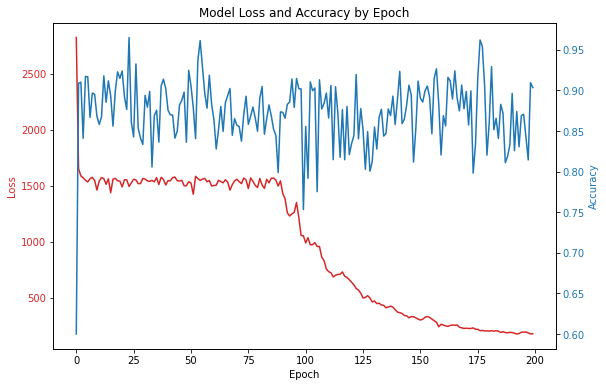

In [10]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color = color)
ax1.plot(LOSS, color = color)
ax1.tick_params(axis='y', labelcolor = color)

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color = color)
ax2.plot(ACCU, color = color)
ax2.tick_params(axis='y', labelcolor = color)
plt.title('Model Loss and Accuracy by Epoch')
fig.set_size_inches(9, 6)

In [13]:
torch.save(model, 'prediction_model.pt')